<a href="https://colab.research.google.com/github/aditi2495/Credit-Card-Financial-Dashboard/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
#Imported the Brain Tumor dataset from kaggle website.
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [46]:
#
import os

# List the top-level directories/files to understand the structure
top_items = os.listdir(path)
print(f"Dataset structure: {top_items}")

# Count the number of images in each directory (if the structure has yes/no folders)
for item in top_items:
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"Number of files in {item}: {num_files}")

Dataset structure: ['no', 'yes', 'brain_tumor_dataset']
Number of files in no: 98
Number of files in yes: 155
Number of files in brain_tumor_dataset: 2


The dataset has three directories:

no: Contains 98 MRI images without tumors (negative cases)
yes: Contains 155 MRI images with tumors (positive cases)
brain_tumor_dataset: Contains only 2 files (likely metadata or summary files)



This is a typical binary classification dataset structure with an imbalance between classes (155 positive cases vs 98 negative cases).


In [47]:
#Libraries to import
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

**Brain Tumor Image Visualization**

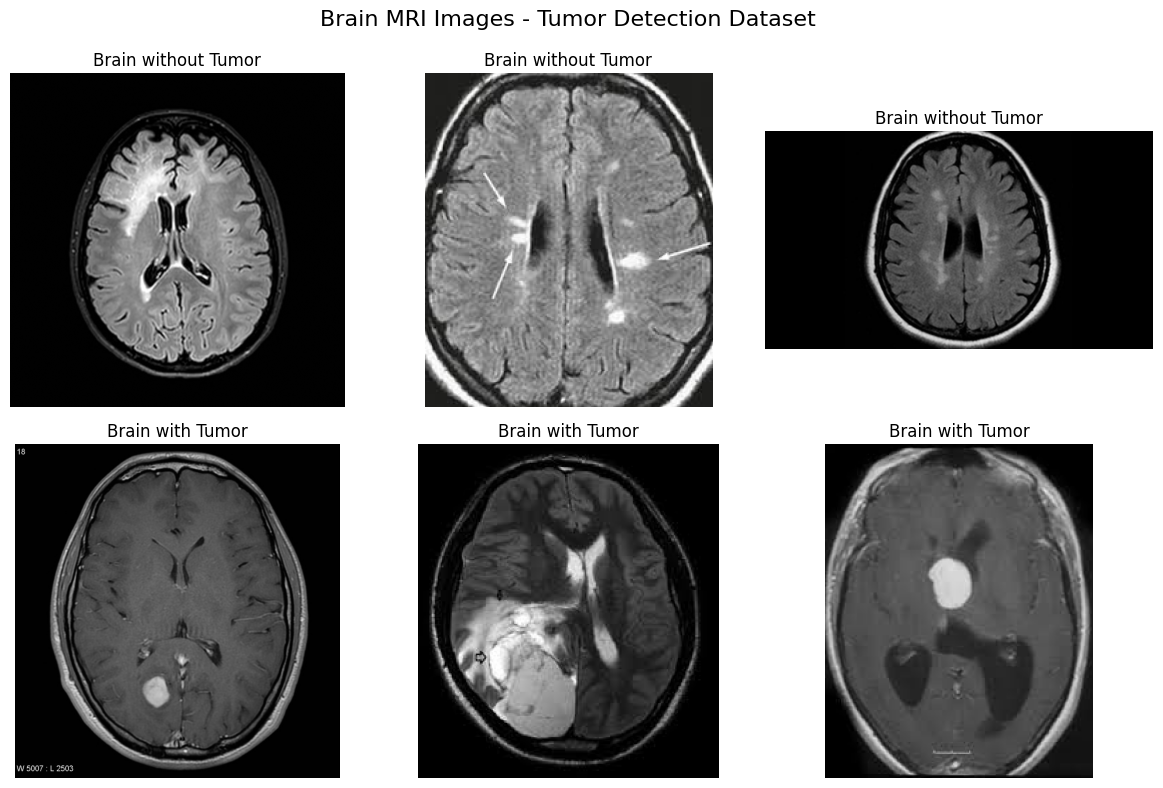

In [48]:
# Function to display sample images from both categories
def display_brain_mri_samples(num_samples=3):
    # Set up the figure with a title
    plt.figure(figsize=(12, 8))
    plt.suptitle('Brain MRI Images - Tumor Detection Dataset', fontsize=16)

    # Create a 2x3 grid of subplots (2 rows, 3 columns)
    for i in range(2):  # Loop through the two categories (no/yes)
        category = 'no' if i == 0 else 'yes'
        category_path = os.path.join(path, category)

        # Get all image files in this category
        images = os.listdir(category_path)

        # Randomly select images
        selected_images = random.sample(images, num_samples)

        # Plot each selected image
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)

            # Create subplot position (i=row, j=column)
            plt.subplot(2, num_samples, i*num_samples + j + 1)

            # Display the image
            plt.imshow(np.array(img), cmap='gray')

            # Set title based on category
            title = f"Brain without Tumor" if category == 'no' else f"Brain with Tumor"
            plt.title(title)

            # Hide axes for cleaner display
            plt.axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Display 3 samples from each category
display_brain_mri_samples(3)

In the tumor images, you can clearly see:
Normal brain MRIs (like those shown):

Symmetrical structure between left and right hemispheres.
Consistent tissue density/intensity.
Clear boundaries between gray and white matter.
Well-defined ventricles (fluid-filled spaces).
Absence of abnormal masses, lesions, or irregular structures.
Uniform signal intensity across similar tissue types.

Brain MRIs with tumors (not shown in your image) would typically display:

Asymmetrical abnormalities.
Areas with abnormal brightness or darkness compared to surrounding tissue.
Mass effect (displacement of normal structures).
Irregular borders.
Edema (swelling) around the tumor.
Enhancement patterns if contrast was used.
Disruption of normal brain anatomy.

**Preprocessing & Data Augmentation Setup**

In [49]:
# Step: Split Dataset into Train / Val / Test

def split_data(source_dir, dest_dir, split_ratio=(0.7, 0.2, 0.1)):
    import shutil
    categories = ['yes', 'no']
    for category in categories:
        src_folder = os.path.join(source_dir, category)
        images = os.listdir(src_folder)
        random.shuffle(images)

        train_size = int(split_ratio[0] * len(images))
        val_size = int(split_ratio[1] * len(images))

        splits = {
            'train': images[:train_size],
            'val': images[train_size:train_size + val_size],
            'test': images[train_size + val_size:]
        }

        for split_name, split_files in splits.items():
            split_folder = os.path.join(dest_dir, split_name, category)
            os.makedirs(split_folder, exist_ok=True)

            for img in split_files:
                src_img_path = os.path.join(src_folder, img)
                dst_img_path = os.path.join(split_folder, img)
                shutil.copy2(src_img_path, dst_img_path)

# Call the function
split_data(path, 'brain_tumor_split')


In [50]:
# Data generators

# Train data generator (with augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test data generator (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create the train generator
train_generator = train_datagen.flow_from_directory(
    'brain_tumor_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Create the validation generator
val_generator = val_test_datagen.flow_from_directory(
    'brain_tumor_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Create the test generator
test_generator = val_test_datagen.flow_from_directory(
    'brain_tumor_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 229 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


The code begins by splitting the Brain Tumor dataset into training, validation, and test sets using a custom function, split_data(), which organizes the images into respective folders. It then applies data preprocessing by rescaling the images and performs data augmentation (such as rotation, shifting, and flipping) only on the training set to help the model generalize better. The code uses ImageDataGenerator to load the images from the directories and prepare them for training. The training, validation, and test sets are now ready for use in model training and evaluation.

**Model Building**

**VGG16**

In [51]:
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras import layers, models
#from tensorflow.keras.optimizers import Adam


# Load VGG16 model (without the top layer, as we will add a custom one)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Build the custom model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Convolutional Neural Network(CNN)**

In [52]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 **ResNet50 Model**

In [53]:

# Load ResNet50 model (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
base_model.trainable = False

# Build the custom model on top of ResNet50
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,433,025 (138.98 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Training the Model**

In [54]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.6438 - loss: 0.7833 - val_accuracy: 0.4659 - val_loss: 0.8027
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.5513 - loss: 0.7919 - val_accuracy: 0.6364 - val_loss: 0.6259
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.6356 - loss: 0.6482 - val_accuracy: 0.6932 - val_loss: 0.6058
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.6788 - loss: 0.5902 - val_accuracy: 0.7159 - val_loss: 0.5818
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.7469 - loss: 0.5621 - val_accuracy: 0.6932 - val_loss: 0.5983
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.6625 - loss: 0.5864 - val_accuracy: 0.7841 - val_loss: 0.5621
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.6965 - loss: 0.5852 - val_accuracy: 0.7159 - val_loss: 0.5550
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - accuracy: 0.6907 - loss: 0.5877 - val_accuracy: 0.7045 - val_loss: 0.5447
Epoch 9/

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training when the validation loss is not improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7065 - loss: 0.5599

8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.7076 - loss: 0.5588 - val_accuracy: 0.7045 - val_loss: 0.5361
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.6757 - loss: 0.5606 - val_accuracy: 0.7159 - val_loss: 0.5541
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.7577 - loss: 0.5571 - val_accuracy: 0.7500 - val_loss: 0.5402
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - accuracy: 0.7350 - loss: 0.5535 - val_accuracy: 0.7159 - val_loss: 0.5481
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6621 - loss: 0.5981

8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.6642 - loss: 0.5964 - val_accuracy: 0.7045 - val_loss: 0.5272
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.7055 - loss: 0.5547 - val_accuracy: 0.7273 - val_loss: 0.5313
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6570 - loss: 0.5910

8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.6588 - loss: 0.5921 - val_accuracy: 0.7727 - val_loss: 0.5244
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.6694 - loss: 0.6060 - val_accuracy: 0.7159 - val_loss: 0.5884
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.7141 - loss: 0.5518 - val_accuracy: 0.7159 - val_loss: 0.5590
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 8s/step - accuracy: 0.6914 - loss: 0.5559 - val_accuracy: 0.7045 - val_loss: 0.5543


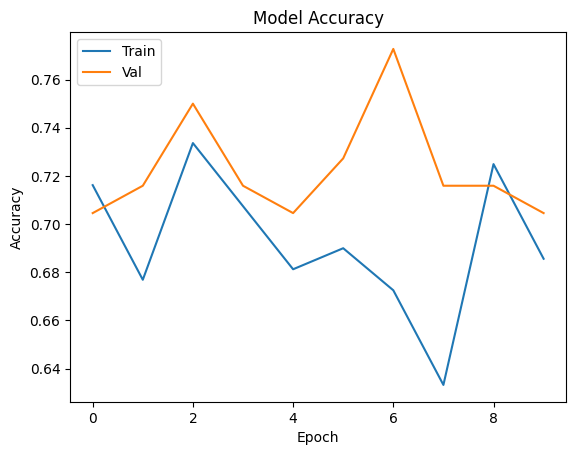

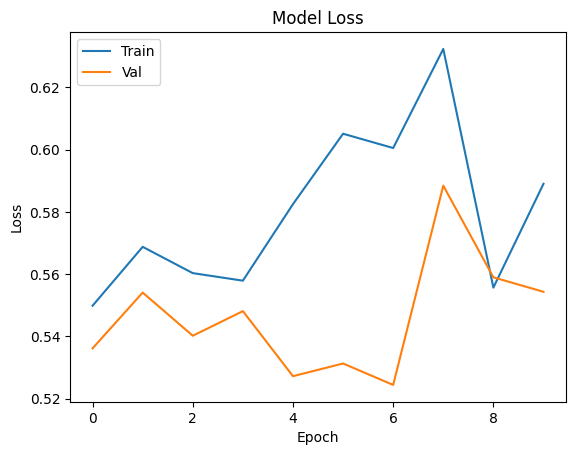

In [56]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7430 - loss: 0.5556
Test accuracy: 0.7551
Test loss: 0.5534
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        20
           1       0.77      0.83      0.80        29

    accuracy                           0.76        49
   macro avg       0.75      0.74      0.74        49
weighted avg       0.75      0.76      0.75        49



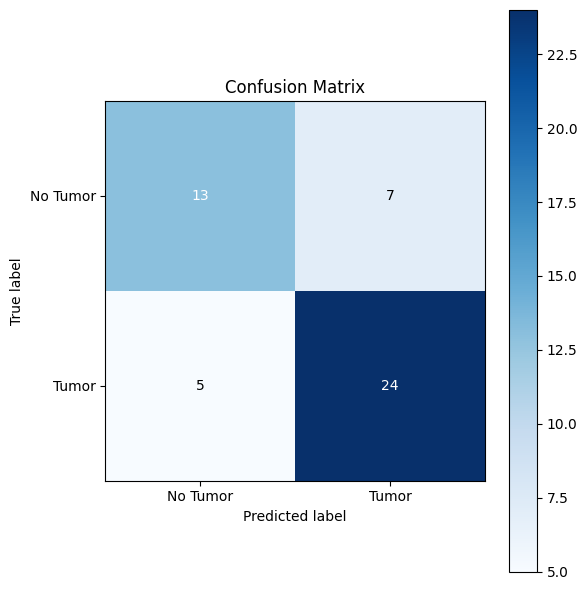

In [57]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Generate predictions
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

# Compute metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot confusion matrix
import numpy as np
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['No Tumor', 'Tumor'],
       yticklabels=['No Tumor', 'Tumor'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()